<a href="https://colab.research.google.com/github/EliasEconomou/DataMining2-Travel-Time-Prediction/blob/main/DataMining2_Travel_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Reading Files**

In [1]:
import numpy as np
import pandas as pd
import sys
import os.path
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Options
pd.options.mode.chained_assignment = None


In [3]:
# Read data files
def read_file(filePath):
  fileExists = os.path.exists(filePath)
  if fileExists:
    rFile = pd.read_csv(filePath)
  else:
    print('Enter data file path:')
    filePath = input()
    rFile = pd.read_csv(filePath)
  return rFile

In [4]:
# Reading train/test/target data files
trainFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/train.csv"
testFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/test.csv"
targetFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/target.csv"


In [5]:
train = read_file(trainFilePath)
test = read_file(testFilePath)
target = read_file(targetFilePath)

train.dropna(inplace = True)
test.dropna(inplace = True)
target.dropna(inplace = True)

print(train.shape,test.shape,target.shape)

(1166915, 11) (291729, 9) (291729, 2)


In [6]:
# Choose a subset - percentage of the dataset's rows
def select_dfsubset(initDF, percentage):
  numOfRows = initDF.shape[0]
  newDF = initDF.iloc[:int(percentage*0.01*numOfRows)]
  return newDF

# **Analyzing Data**

In [7]:
# We can choose a subset of our train dataset to analyze
percentage = 10
trainDF = select_dfsubset(train,percentage)
print("Chosen number of tweets is {} - {}% of the given dataset.".format(trainDF.shape[0], percentage))

Chosen number of tweets is 116691 - 10% of the given dataset.


##*1. Removing outliers*

In [38]:
# Getting some basic statistics of out dataset with trip duration outliers
statistics = trainDF.describe()
tripDurMean = statistics["trip_duration"]["mean"]
tripDurStd = statistics["trip_duration"]["std"]
statistics

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,116691.000000,116691.000000,116691.000000,116691.000000,116691.000000,116691.000000,116691.000000
mean,1.534197,1.662682,-73.973484,40.751012,-73.973288,40.751984,944.695735
std,0.498831,1.309708,0.039467,0.029052,0.037534,0.033347,3091.959061
min,1.000000,0.000000,-75.238327,39.923027,-74.705360,40.271030,1.000000
25%,1.000000,1.000000,-73.991806,40.737358,-73.991280,40.736092,396.000000
50%,2.000000,1.000000,-73.981827,40.754120,-73.979691,40.754536,662.000000
75%,2.000000,2.000000,-73.967377,40.768368,-73.962990,40.769896,1073.000000
max,2.000000,6.000000,-70.851616,43.017578,-70.851616,43.017578,86362.000000


In [29]:
# Trip duration outlier is considered to be every value 2 standard deviations
# away from the mean
upperOutlier = tripDurMean+2*tripDurStd
lowerOutlier = tripDurMean-2*tripDurStd

is_outlier = np.where((trainDF.trip_duration >= upperOutlier) | (trainDF.trip_duration <= lowerOutlier),"outlier","inlier")

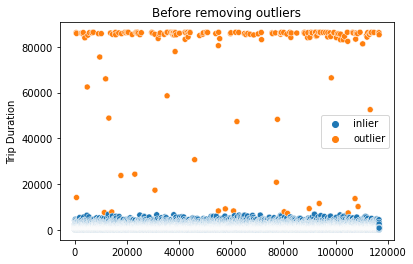

In [37]:
# x-axis values
x_values = range(trainDF.trip_duration.shape[0])

# y-axis values
y_values = trainDF.trip_duration

plotWithOutliers = sns.scatterplot(data=y_values,
                                   y=y_values,
                                   x=x_values,
                                   hue=is_outlier).set(title="Before removing outliers",
                                                       ylabel = "Trip Duration")


In [40]:
# Now let's remove all rows with trip duration outliers
trainDF = trainDF.drop(trainDF[trainDF.trip_duration > upperOutlier].index)
trainDF = trainDF.drop(trainDF[trainDF.trip_duration < lowerOutlier].index)

# Print the new statistics
newStatistics = trainDF.describe()
newTripDurMean = newStatistics["trip_duration"]["mean"]
newTripDurStd = newStatistics["trip_duration"]["std"]
newStatistics

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,116520.000000,116520.000000,116520.000000,116520.000000,116520.000000,116520.000000,116520.000000
mean,1.533565,1.662144,-73.973483,40.751031,-73.973288,40.751985,833.789264
std,0.498874,1.309090,0.039264,0.028940,0.037533,0.033346,649.310595
min,1.000000,0.000000,-74.705368,40.276291,-74.705360,40.271030,1.000000
25%,1.000000,1.000000,-73.991798,40.737370,-73.991280,40.736092,396.000000
50%,2.000000,1.000000,-73.981827,40.754129,-73.979691,40.754539,661.000000
75%,2.000000,2.000000,-73.967377,40.768372,-73.962990,40.769901,1070.000000
max,2.000000,6.000000,-70.851616,43.017578,-70.851616,43.017578,6900.000000


In [45]:
# Compute new outliers
newUpperOutlier = tripDurMean+2*tripDurStd
newLowerOutlier = tripDurMean-2*tripDurStd

new_is_outlier = np.where((trainDF.trip_duration >= newUpperOutlier) | (trainDF.trip_duration <= newLowerOutlier),"outlier","inlier")

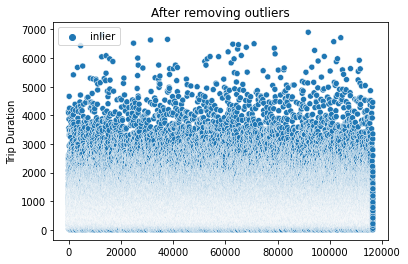

In [48]:
# x-axis values
x_values = range(trainDF.trip_duration.shape[0])

# y-axis values
y_values = trainDF.trip_duration

plotWithOutliers = sns.scatterplot(data=y_values,
                                   y=y_values,
                                   x=x_values,
                                   hue=new_is_outlier).set(title="After removing outliers",
                                                       ylabel = "Trip Duration")

##*2. Remove any points outside NY*